In [11]:
!pip install lightgbm shap pandas numpy streamlit


In [44]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import gradio as gr

df = pd.read_csv('credit_risk_dataset.csv')
df = df.dropna()

# Encode categorical features and save mappings for Gradio
cat_maps = {}
for col in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    cat_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

X = df.drop(['loan_status'], axis=1)
y = df['loan_status']



In [48]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


In [45]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 64,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)



Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[245]	valid_0's auc: 0.9494


AUC: 0.9494
Accuracy: 0.9232


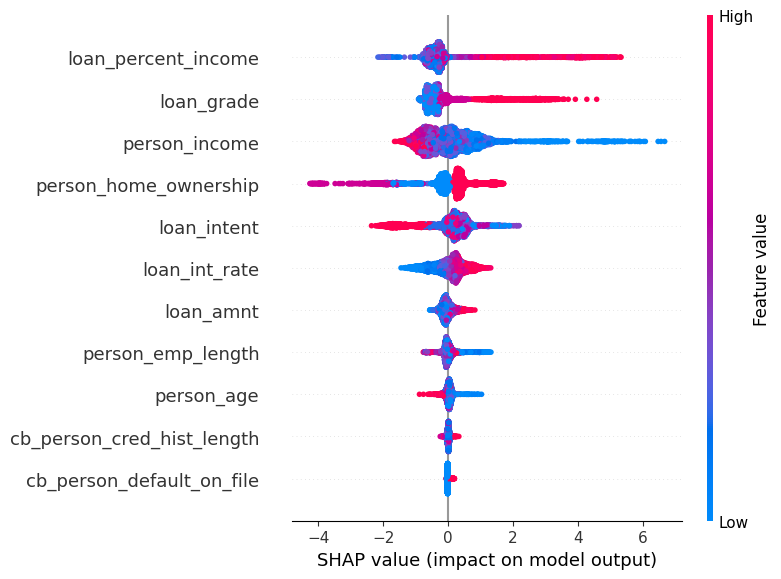

In [46]:

y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred.round())
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


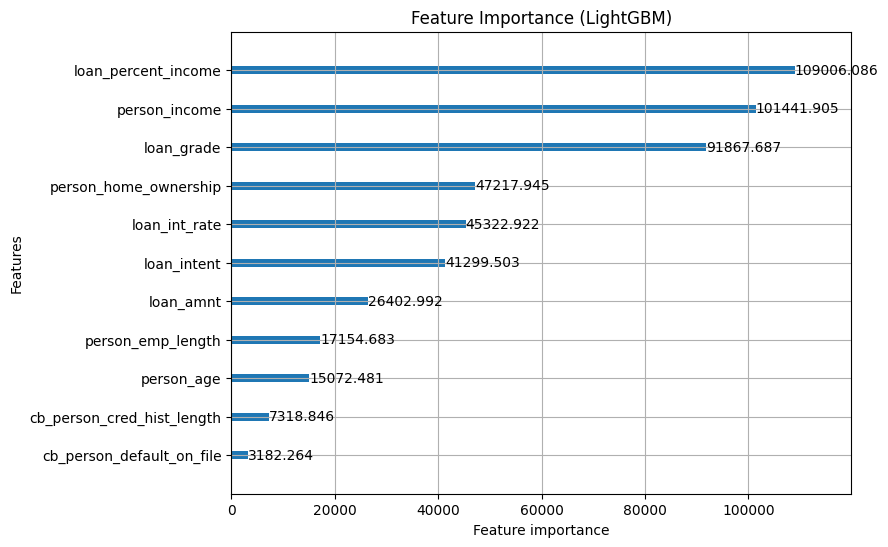

In [52]:
import lightgbm as lgb

# If you trained a LightGBM model:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 6))
plt.title('Feature Importance (LightGBM)')
plt.show()


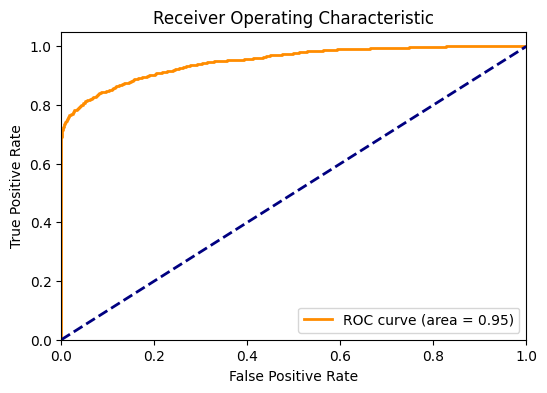

In [50]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


<Figure size 1000x400 with 0 Axes>

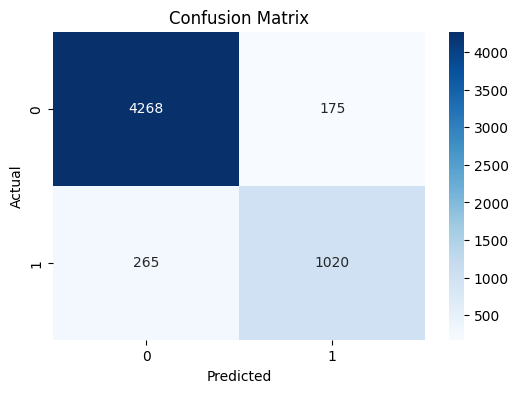

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4443
           1       0.85      0.79      0.82      1285

    accuracy                           0.92      5728
   macro avg       0.90      0.88      0.89      5728
weighted avg       0.92      0.92      0.92      5728



In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred.round()))


In [47]:
def predict_credit_score(
    person_age,
    person_income,
    person_home_ownership,
    person_emp_length,
    loan_intent,
    loan_grade,
    loan_amnt,
    loan_int_rate,
    loan_percent_income,
    cb_person_default_on_file,
    cb_person_cred_hist_length
):
    # Map categorical inputs using saved encoders
    try:
        home_ownership = cat_maps['person_home_ownership'][person_home_ownership]
        intent = cat_maps['loan_intent'][loan_intent]
        grade = cat_maps['loan_grade'][loan_grade]
        default_file = cat_maps['cb_person_default_on_file'][cb_person_default_on_file]
    except Exception as e:
        return f"Input mapping error: {e}", None

    # Prepare input for prediction
    input_data = pd.DataFrame([[
        person_age,
        person_income,
        home_ownership,
        person_emp_length,
        intent,
        grade,
        loan_amnt,
        loan_int_rate,
        loan_percent_income,
        default_file,
        cb_person_cred_hist_length
    ]], columns=X_train.columns)

    # Predict
    score = model.predict(input_data)[0]

    # SHAP explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(input_data)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    plt.figure(figsize=(10, 4))
    shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values[0],
        input_data.iloc[0],
        feature_names=X_train.columns.tolist(),
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    fig = plt.gcf()
    plt.close()
    return f"Risk Score (prob. default): {score:.4f}", fig

# 11. Gradio interface
inputs = [
    gr.Number(label="Age", value=30),
    gr.Number(label="Income", value=50000),
    gr.Dropdown(label="Home Ownership", choices=list(cat_maps['person_home_ownership'].keys()), value="RENT"),
    gr.Number(label="Employment Length (years)", value=5),
    gr.Dropdown(label="Loan Intent", choices=list(cat_maps['loan_intent'].keys()), value="PERSONAL"),
    gr.Dropdown(label="Loan Grade", choices=list(cat_maps['loan_grade'].keys()), value="C"),
    gr.Number(label="Loan Amount", value=10000),
    gr.Number(label="Interest Rate (%)", value=10),
    gr.Number(label="Loan Percent Income", value=0.5),
    gr.Dropdown(label="Default on File", choices=list(cat_maps['cb_person_default_on_file'].keys()), value="N"),
    gr.Number(label="Credit History Length", value=3),
]
outputs = [
    gr.Textbox(label="Prediction"),
    gr.Plot(label="SHAP Explanation")
]
interface = gr.Interface(
    fn=predict_credit_score,
    inputs=inputs,
    outputs=outputs,
    title="Credit Scoring with Real Data",
    description="Predict credit risk using real credit risk features"
)
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c527a8f069456c59a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
